### replace default value of argument (e.g. `gamma`, `hi_min`) to defined values in module file

In [24]:
import numpy as np
import matplotlib.pyplot as plt

In [49]:
from math import sqrt
from numbers import Real

def get_stepsize_quad(ti, xi, Fx, dxFx, dx2Fx, hi_max,
                     gamma = 0.8, hi_min = 0.005, forward=True):
    
    if not forward: raise NotImplementedError(
        "backward time flow hasn't been dealt yet")
    assert isinstance(gamma, Real) and (0 < gamma) and (gamma < 1)
    
    _hi_guess = None
    
    ## initial guess of stepsize
    _F_tixi, _dxFx_tixi, _dx2Fx_tixi = Fx(ti,xi), dxFx(ti,xi), dx2Fx(ti,xi)
    _a1_0 = _dxFx_tixi*_dxFx_tixi - 2.0 * _dx2Fx_tixi * _F_tixi
    _a2_0 = _dxFx_tixi
    _D_D = _a2_0 * _a2_0 - _a1_0
    
    if _a1_0 > 0:
        if _a2_0 <= 0: _hi_guess = hi_max
        else:
            if _D_D >= 0: _hi_guess = gamma * _a2_0 / _a1_0
            else: _hi_guess = hi_max
    elif _a1_0 < 0: _hi_guess = gamma * (_a2_0 + sqrt(_D_D)) / (2.0 * _a1_0)
    elif _a1_0 == 0:
        if _a2_0 > 0: _hi_guess = gamma / (2.0 * _a2_0)
        else: _hi_guess = hi_max
    else: raise Exception("Unexpected")
    
    assert isinstance(_hi_guess, Real)

    
    ## fine-tune
    _a1, _a2 = _a1_0, _a2_0
    while _hi_guess > hi_min:
        _D_hi = _a1 * _hi_guess*_hi_guess - 2.0 * _a2 * _hi_guess + 1
        if _D_hi > 0: break
        _ti = ti + _hi_guess
        _F, _dxFx, _dx2Fx = Fx(_ti,xi), dxFx(_ti,xi), dx2Fx(_ti,xi)
        _a1 = _dxFx*_dxFx - 2.0 * _dx2Fx * _F
        _a2 = _dxFx
        _hi_guess *= gamma
    
    if (_hi_guess <= hi_min):
        raise Exception("hi_min reached - couldn't find good stepsize")         
    _hi = min(_hi_guess, hi_max)
    
    return _hi

In [50]:
import numpy as np
from scipy.optimize import root

def back_euler_quad(t0, x0, t_max, Fx, dxFx, dx2Fx, hi_max, **stepsize_kwarg):              
    _t_list = [t0]
    _x_list = [x0]

    while _t_list[-1] < t_max:
        _ti, _xi = _t_list[-1], _x_list[-1]
        _hi = get_stepsize_quad(_ti, _xi, Fx, dxFx, dx2Fx, hi_max, **stepsize_kwarg)        
        _t_next = _ti + _hi
        def _Gx(x): return (x - _xi) - _hi * Fx(_t_next, x)
        _sol = root(_Gx, _xi)  # jacobian may be supplied
        if _sol.success and _sol.x.size == 1: _x_next, = _sol.x
        else: raise Exception(
            "unique root search failed due to '{}'".format(_sol.message))       
        _t_list.append(_t_next), _x_list.append(_x_next)

    _t_arr, _x_arr = np.array(_t_list), np.array(_x_list)
    return _t_arr, _x_arr


In [51]:
c0, c1 = 0.2, 1.0
def Fx(t, x): return c0 + c1*x
def dxFx(t, x): return c1
def dx2Fx(t, x): return 0.0

t0, x0 = -0.5, -1.1

In [8]:
get_stepsize_quad(t0, x0, Fx, dxFx, dx2Fx, hi_max=1.0)

0.8

In [74]:
from matplotlib import rcParams
rcParams['font.size'] = 15

In [83]:
def Fx(t, x): return x*x
def dxFx(t, x): return 2.0*x
def dx2Fx(t, x): return 2.0

t0, x0 = -0.5, 1.1
t_max = 0.0
h_max = 0.01

def x_analytic(t): return - 1.0 / (t - t0 - 1.0/x0)

t_arr, x_arr = back_euler_quad(t0, x0, t_max, Fx, dxFx, dx2Fx, hi_max=h_max)
f_arr = x_analytic(t_arr)

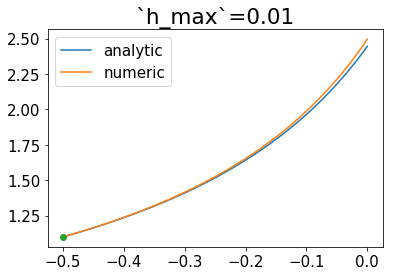

In [84]:
fig, ax = plt.subplots()

l_ana, = ax.plot(t_arr, f_arr)
l_num, = ax.plot(t_arr, x_arr)

ax.plot(t0, x0, 'o')

ax.set_title("`h_max`={}".format(h_max))
ax.legend((l_ana, l_num), ("analytic", "numeric"))

# ax.set_ylim(-1000,0)

In [85]:
# fig.savefig("step-esti-quad-hmax-{}-test-0.png".format(h_max))

In [10]:
get_stepsize_quad(t0, x0, Fx, dxFx, dx2Fx, hi_max=1.0)

0.18181818181818182